In [1]:
# Part 1: Pull in Data and Clean It
# Part 2: Create First Models
# Part 3: Create Second Models

In [2]:
# Logistic/Linear  look at coeeffients
# 30 biggest & 30 smallest most predictive
# Random Forest - feauture importances
# Should be predictive but is not there yet?  
# Did you change anything in data processing that is screwing up your variable predictivity?
# Do you need to add any data?
# At this point put in all of the columns
# Once satisfied, try a more sophisticated model

In [3]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
plt.style.use('ggplot')
from sklearn import tree
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [4]:
# Load Expiration Data
NFL_path = "NFL Play by Play 2009-2016 (v3).csv"
NFL_DF = pd.read_csv(NFL_path)

/Users/nicholashebert/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Convert Columns to Numbers & Create Columns
NFL_DF["Pass_Distance"] = np.where(NFL_DF["PassLength"] == "Short", 1, 0)
NFL_DF["InTheirRedzone"] = np.where(NFL_DF["yrdline100"] >= 20, 1, 0)
NFL_DF["GameID1Down"] = NFL_DF["GameID"].shift(-1)

In [6]:
# How many yards they got on the drive
yards_by_drive = NFL_DF.groupby(["GameID", "Drive"])["Yards.Gained"].sum()
# Of the passes they threw, how many did they throw down the field?
PassDistance_by_drive = NFL_DF.groupby(["GameID", "Drive"])["Pass_Distance"].sum()
# How many passes did they throw down the field?
PassAttempt_by_drive = NFL_DF.groupby(["GameID", "Drive"])["PassAttempt"].sum()
# How many times did they run in a drive?
RushAttempt_by_drive = NFL_DF.groupby(["GameID", "Drive"])["RushAttempt"].sum()
# If they run a play from their opponents endzone on the drive than this column will be greater than 0
TheirRedzone_by_drive = NFL_DF.groupby(["GameID", "Drive"])["InTheirRedzone"].sum()
# If they scored a touchdown on that drive
ScoreTouchdown_by_drive = NFL_DF.groupby(["GameID", "Drive"])["Touchdown"].sum()
# If they kicked a field goal on that drive is greater than zero
KickFieldGoal_by_drive = NFL_DF.groupby(["GameID", "Drive"])["FieldGoalDistance"].sum()
# How far did they try to throw it on the drive?
AirYards_by_drive = NFL_DF.groupby(["GameID", "Drive"])["AirYards"].sum()

In [7]:
NFL1_DF = NFL_DF.join(yards_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL2_DF = NFL1_DF.join(PassDistance_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL3_DF = NFL2_DF.join(PassAttempt_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL4_DF = NFL3_DF.join(TheirRedzone_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL5_DF = NFL4_DF.join(ScoreTouchdown_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL6_DF = NFL5_DF.join(KickFieldGoal_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL7_DF = NFL6_DF.join(RushAttempt_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL8_DF = NFL7_DF.join(AirYards_by_drive, on=["GameID", "Drive"], rsuffix="Computed_")
NFL8_DF["RushAttemptComputed_"].dtypes

dtype('int64')

Rush Attempts by Drive
Yards gained by Drive


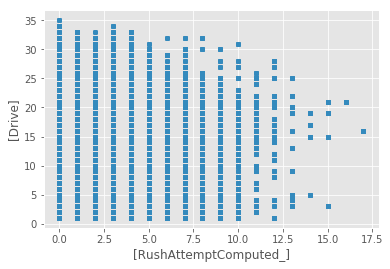

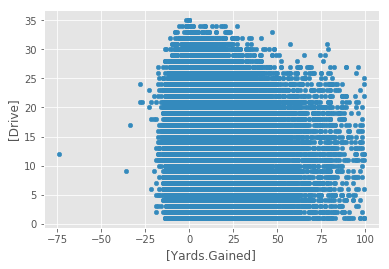

In [8]:
# Vizualize the data 

print("Rush Attempts by Drive")
NFL8_DF.plot.scatter(x=["RushAttemptComputed_"], y=["Drive"])

print("Yards gained by Drive")
NFL8_DF.plot.scatter(x=["Yards.Gained"], y=["Drive"])


In [9]:
# Create metrics for Algorithims
# The Pass/Run Ratio of a Drive
NFL8_DF["PassToRushRatioOnDrive"] = (NFL8_DF["PassAttemptComputed_"] / NFL8_DF["PassAttemptComputed_"].add(NFL8_DF["RushAttemptComputed_"]))

In [10]:
final_df = NFL8_DF.fillna(0)
print(NFL8_DF.shape)
print(final_df.shape)

(362447, 114)
(362447, 114)


In [11]:
# Create Dummy Columns using One Hot Encoding
Passer = pd.Series(final_df["Passer"])
Rusher = pd.Series(final_df["Rusher"])
DTeam = pd.Series(final_df["DefensiveTeam"])
RunLoc = pd.Series(final_df["RunLocation"])
RunGap = pd.Series(final_df["RunGap"])
PassLoc = pd.Series(final_df["PassLocation"])
DTeam1 = pd.get_dummies(DTeam)
RunLoc1 = pd.get_dummies(RunLoc)
RunGap1 = pd.get_dummies(RunGap)
PassLoc1 = pd.get_dummies(PassLoc)
Rusher1 = pd.get_dummies(Rusher)
Passer1 = pd.get_dummies(Passer)

In [12]:
# Merge the new dummy dataframes with the rest of the data
final_df = pd.concat([final_df, DTeam1], axis=1)
final_df = pd.concat([final_df, RunGap1], axis=1)
final_df = pd.concat([final_df, PassLoc1], axis=1)
final_df = pd.concat([final_df, RunLoc1], axis=1)
final_df = pd.concat([final_df, Rusher1], axis=1)
final_df = pd.concat([final_df, Passer1], axis=1)

In [13]:
# Start with an ultra simplistic view of the game.  How often are you running v. passing, how far are you trying to pass?
y = final_df["Yards.GainedComputed_"]
X = final_df[["PassToRushRatioOnDrive", "Pass_DistanceComputed_", "AirYardsComputed_"]]



In [14]:
# Dataset after adding in new stats about players and teams
y1 = final_df["Yards.GainedComputed_"]
X1 = final_df[["Season", "PassToRushRatioOnDrive", "Pass_DistanceComputed_", "AirYardsComputed_", "ARI", "ATL", "BAL", "BUF", "CAR", "CHI", "CIN", "CLE", "DAL", "DEN", "DET",  "GB", "HOU", "IND", "JAC", "JAX",  "KC",  "LA", "MIA", "MIN",  "NE",  "NO", "NYG", "NYJ", "OAK", "PHI", "PIT",  "SD", "SEA", "SF", "STL",  "TB", "TEN", "WAS", "end", "guard", "tackle", "A. Bradshaw",
 "A.Abdullah",
 "A.Allen",
 "A.Andrews",
 "A.Armstrong",
 "A.Bailey",
 "A.Benn",
 "A.Blue",
 "A.Boldin",
 "A.Boone",
 "A.Bradford",
 "A.Bradshaw",
 "A.Brown",
 "A.Caldwell",
 "A.Collie",
 "A.Collins",
 "A.Cooper",
 "A.Cromartie",
 "A.Dalton",
 "A.Davis",
 "A.Dixon",
 "A.Edwards",
 "A.Ellington",
 "A.Feeley",
 "A.Foster",
 "A.Green",
 "A.Hall",
 "A.Harris",
 "A.Hawkins",
 "A.Hernandez",
 "A.Humphries",
 "A.Hunt",
 "A.Janovich",
 "A.Jeffery",
 "A.Jenkins",
 "A.Johnson",
 "A.Lee",
 "A.Luck",
 "A.McCarron",
 "A.Morris",
 "A.Peterson",
 "A.Pettis",
 "A.Podlesh",
 "A.Randle El",
 "A.Ripkowski",
 "A.Roberts",
 "A.Robinson",
 "A.Rodgers",
 "A.Rolle",
 "A.Sanders",
 "A.Sendejo",
 "A.Sherman",
 "A.Smith",
 "A.Snyder",
 "A.Stecker",
 "A.Thielen",
 "A.Villanueva",
 "A.Williams",
 "A.Wilson",
 "A.Young",
 "Al.Robinson",
 "Alf.Smith",
 "Ar.Smith",
 "B. Gradkowski",
 "B. Smith",
 "B. Westbrook",
 "B.Addison",
 "B.Askew",
 "B.Ayanbadejo",
 "B.Banks",
 "B.Batch",
 "B.Berrian",
 "B.Bolden",
 "B.Bolen",
 "B.Bortles",
 "B.Brown",
 "B.Burks",
 "B.Carpenter",
 "B.Colquitt",
 "B.Cooks",
 "B.Cunningham",
 "B.Daniels",
 "B.Edwards",
 "B.Ellington",
 "B.Favre",
 "B.Fields",
 "B.Gabbert",
 "B.Gibson",
 "B.Gradkowski",
 "B.Graham",
 "B.Green-Ellis",
 "B.Hartline",
 "B.Hill",
 "B.Hoover",
 "B.Hoyer",
 "B.Hundley",
 "B.Jackson",
 "B.Jacobs",
 "B.Johnson",
 "B.Kern",
 "B.LaFell",
 "B.Leftwich",
 "B.Leonard",
 "B.Lloyd",
 "B.Logan",
 "B.Marquez",
 "B.Marshall",
 "B.McManus",
 "B.Mebane",
 "B.Miller",
 "B.Moorman",
 "B.Nortman",
 "B.Obomanu",
 "B.Oliver",
 "B.Osweiler",
 "B.Pascoe",
 "B.Perriman",
 "B.Petty",
 "B.Pierce",
 "B.Powell",
 "B.Quinn",
 "B.Qvale",
 "B.Rainey",
 "B.Raji",
 "B.Roethlisberger",
 "B.Saine",
 "B.Sankey",
 "B.Scott",
 "B.Smith",
 "B.St",
 "B.Tate",
 "B.Treggs",
 "B.Wade",
 "B.Walters",
 "B.Watson",
 "B.Weeden",
 "B.Westbrook",
 "B.Wilds",
 "B.Wing",
 "Be.Scott",
 "C. Daniel",
 "C. Hanie",
 "C. Henne",
 "C. Kaepernick",
 "C. Laepernick",
 "C. McCoy",
 "C. Redman",
 "C.Anderson",
 "C.Artis-Payne",
 "C.Batch",
 "C.Benson",
 "C.Brinkley",
 "C.Brown",
 "C.Buckhalter",
 "C.Clark",
 "C.Clay",
 "C.Clemons",
 "C.Coleman",
 "C.Cooley",
 "C.Crocker",
 "C.Dahl",
 "C.Daniel",
 "C.Daniels",
 "C.Davis",
 "C.Fleener",
 "C.Fleming",
 "C.Frye",
 "C.Givens",
 "C.Grant",
 "C.Gray",
 "C.Gronkowski",
 "C.Hall",
 "C.Hanie",
 "C.Henne",
 "C.Hilliard",
 "C.Hogan",
 "C.Hyde",
 "C.Ivory",
 "C.Jennings",
 "C.Johnson",
 "C.Jones",
 "C.Kaepernick",
 "C.Keenum",
 "C.Kessler",
 "C.Kluwe",
 "C.Kouandjio",
 "C.Latimer",
 "C.Leno",
 "C.Lucas",
 "C.Lynch",
 "C.Maragos",
 "C.McCoy",
 "C.McIntyre",
 "C.Meredith",
 "C.Michael",
 "C.Mitchell",
 "C.Mooney",
 "C.Moore",
 "C.Morrah",
 "C.Newton",
 "C.Ochocinco",
 "C.Ogbonnaya",
 "C.Owusu",
 "C.Painter",
 "C.Palmer",
 "C.Patterson",
 "C.Peerman",
 "C.Pennington",
 "C.Polk",
 "C.Ponder",
 "C.Portis",
 "C.Pressley",
 "C.Procter",
 "C.Prosinski",
 "C.Prosise",
 "C.Rachal",
 "C.Rainey",
 "C.Redman",
 "C.Robinson",
 "C.Schmidt",
 "C.Scott",
 "C.Shaw",
 "C.Shorts",
 "C.Simpson",
 "C.Sims",
 "C.Smith",
 "C.Spencer",
 "C.Spiller",
 "C.Stuckey",
 "C.Taylor",
 "C.Thompson",
 "C.Washington",
 "C.Watts",
 "C.Wells",
 "C.Wentz",
 "C.West",
 "C.White",
 "C.Whitehurst",
 "C.Williams",
 "C.Wilson",
 "C.Wood",
 "C.Woodson",
 "C.Yount",
 "Ch.Johnson",
 "D. Jackson",
 "D. Orlovsky",
 "D. Stanton",
 "D.Allen",
 "D.Amendola",
 "D.Anderson",
 "D.Archer",
 "D.Ausberry",
 "D.Avery",
 "D.Ayers",
 "D.Baldwin",
 "D.Bess",
 "D.Booker",
 "D.Bowe",
 "D.Branch",
 "D.Brees",
 "D.Briscoe",
 "D.Brown",
 "D.Bruton",
 "D.Bryant",
 "D.Butler",
 "D.Carr",
 "D.Carrier",
 "D.Carter",
 "D.Clark",
 "D.Clowney",
 "D.Cobb",
 "D.Coleman",
 "D.Colquitt",
 "D.Connolly",
 "D.Culpepper",
 "D.Dickerson",
 "D.Diehl",
 "D.Dixon",
 "D.Dozier",
 "D.Driver",
 "D.Fales",
 "D.Foster",
 "D.Freeman",
 "D.Garrard",
 "D.Gettis",
 "D.Gilreath",
 "D.Goldson",
 "D.Gordon",
 "D.Harris",
 "D.Hawkins",
 "D.Hawthorne",
 "D.Henderson",
 "D.Henry",
 "D.Herron",
 "D.Hester",
 "D.Heyward-Bey",
 "D.Jackson",
 "D.Johnson",
 "D.Johnson Jr",
 "D.Jones",
 "D.Karim",
 "D.Kaser",
 "D.Keller",
 "D.Kelly",
 "D.Kilgore",
 "D.Landry",
 "D.Lasco",
 "D.Lewis",
 "D.Martin",
 "D.Mason",
 "D.McCluster",
 "D.McCray",
 "D.McFadden",
 "D.McNabb",
 "D.Moncrief",
 "D.Moore",
 "D.Murray",
 "D.Nance",
 "D.Orlovsky",
 "D.Patterson",
 "D.Poe",
 "D.Posey",
 "D.Prescott",
 "D.Presley",
 "D.Reaves",
 "D.Reed",
 "D.Reynaud",
 "D.Rhodes",
 "D.Richardson",
 "D.Robinson",
 "D.Rogers",
 "D.Roland",
 "D.Rosario",
 "D.Sanzenbacher",
 "D.Savage",
 "D.Scott",
 "D.Searcy",
 "D.Skuta",
 "D.Sproles",
 "D.Stallworth",
 "D.Stanton",
 "D.Thomas",
 "D.Walker",
 "D.Ward",
 "D.Ware",
 "D.Washington",
 "D.Watt",
 "D.Williams",
 "D.Wilson",
 "D.Woodhead",
 "D.Wynn",
 "D.Yankey",
 "D.Young",
 "Da.Thomas",
 "Da.Williams",
 "Dan.Thomas",
 "De.Williams",
 "Del.Walker",
 "Dn. Thomas",
 "Dn.Thomas",
 "E. Britton",
 "E.Baker",
 "E.Bennett",
 "E.Buckley",
 "E.Decker",
 "E.Doucet",
 "E.Ebron",
 "E.Elliott",
 "E.Foster",
 "E.Gates",
 "E.Graham",
 "E.James",
 "E.Lacy",
 "E.Lorig",
 "E.Manning",
 "E.Manuel",
 "E.Olsen",
 "E.Page",
 "E.Rogers",
 "E.Royal",
 "E.Royster",
 "E.Sanders",
 "E.Weddle",
 "E.Weems",
 "E.Williams",
 "E.Wright",
 "F. Gore",
 "F.Adams",
 "F.Davis",
 "F.Gore",
 "F.Jackson",
 "F.Jones",
 "F.Summers",
 "F.Taylor",
 "F.Toussaint",
 "F.Whittaker",
 "G. Smith",
 "G.Atkinson",
 "G.Bernard",
 "G.Carimi",
 "G.Cherilus",
 "G.Coffee",
 "G.Farmer",
 "G.Gilliam",
 "G.Harrell",
 "G.Jennings",
 "G.Johnson",
 "G.Jones",
 "G.Little",
 "G.McElroy",
 "G.Russell",
 "G.Salas",
 "G.Sanborn",
 "G.Smith",
 "G.Tate",
 "G.Van Roten",
 "G.Whimper",
 "G.Williams",
 "G.Wilson",
 "G.Winn",
 "G.Winston",
 "G.Wolfe",
 "H.Douglas",
 "H.Evans",
 "H.Hynoski",
 "H.Miller",
 "H.Nakamura",
 "H.Nicks",
 "H.Smith",
 "H.Ward",
 "I.Abdul-Quddus",
 "I.Bruce",
 "I.Crowell",
 "I.Pead",
 "I.Redman",
 "J. Brewer",
 "J. Campbell",
 "J. Clausen",
 "J. Cribbs",
 "J. Cutler",
 "J. Garoppolo",
 "J. Johnson",
 "J. Kitna",
 "J. Macklin",
 "J. McGraw",
 "J. Webb",
 "J.Adams",
 "J.Addai",
 "J.Ajayi",
 "J.Allen",
 "J.Arenas",
 "J.Asamoah",
 "J.Aubrey",
 "J.Avant",
 "J.Babineaux",
 "J.Baker",
 "J.Banyard",
 "J.Battle",
 "J.Beck",
 "J.Bell",
 "J.Bellamy",
 "J.Berger",
 "J.Berry",
 "J.Best",
 "J.Bidwell",
 "J.Black",
 "J.Blackmon",
 "J.Brissett",
 "J.Campbell",
 "J.Casey",
 "J.Caulcrick",
 "J.Charles",
 "J.Clausen",
 "J.Clay",
 "J.Collins",
 "J.Conner",
 "J.Cook",
 "J.Cooper",
 "J.Cotchery",
 "J.Cribbs",
 "J.Crockett",
 "J.Crowder",
 "J.Cutler",
 "J.Davis",
 "J.Delhomme",
 "J.Demps",
 "J.Develin",
 "J.Dugan",
 "J.Dwyer",
 "J.Edelman",
 "J.Fargas",
 "J.Feagles",
 "J.Feely",
 "J.Felton",
 "J.Ferguson",
 "J.Fisher",
 "J.Flacco",
 "J.Ford",
 "J.Forsett",
 "J.Fowler",
 "J.Franklin",
 "J.Freeman",
 "J.Gaither",
 "J.Garcia",
 "J.Garoppolo",
 "J.Goff",
 "J.Gordon",
 "J.Graham",
 "J.Grant",
 "J.Gray",
 "J.Griffith",
 "J.Grimes",
 "J.Haden",
 "J.Harper",
 "J.Harris",
 "J.Harrison",
 "J.Hayne",
 "J.Hekker",
 "J.Herndon",
 "J.Hester",
 "J.Higgins",
 "J.Hill",
 "J.Holton",
 "J.Horne",
 "J.Howard",
 "J.Huff",
 "J.Iosefa",
 "J.James",
 "J.Janis",
 "J.Jenkins",
 "J.Jernigan",
 "J.Johnson",
 "J.Jones",
 "J.Kearse",
 "J.Kerley",
 "J.Kerridge",
 "J.Kitna",
 "J.Knox",
 "J.Kuhn",
 "J.Landry",
 "J.Lane",
 "J.Langford",
 "J.Laurinaitis",
 "J.Lewis",
 "J.Linkenbach",
 "J.Locke",
 "J.Locker",
 "J.Looney",
 "J.Losman",
 "J.Maclin",
 "J.Manziel",
 "J.Mauga",
 "J.McCown",
 "J.McCown Aborted",
 "J.McKinnon",
 "J.McKissic",
 "J.McKnight",
 "J.Morgan",
 "J.Nelson",
 "J.Norwood",
 "J.Olawale",
 "J.Parmele",
 "J.Poutasi",
 "J.Poyer",
 "J.Prosch",
 "J.Randle",
 "J.Reed",
 "J.Reid",
 "J.Reitz",
 "J.Richard",
 "J.Ringer",
 "J.Robinson",
 "J.Rodgers",
 "J.Ross",
 "J.Russell",
 "J.Ryan",
 "J.Senn",
 "J.Simpson",
 "J.Skelton",
 "J.Smith",
 "J.Snelling",
 "J.Starks",
 "J.Stewart",
 "J.Thompson",
 "J.Todman",
 "J.Tretter",
 "J.Tuck",
 "J.Tucker",
 "J.Tuel",
 "J.Urban",
 "J.Vaughan",
 "J.Webb",
 "J.White",
 "J.Williams",
 "J.Winston",
 "J.Wright",
 "JO.Brown",
 "Jo. Brown",
 "Jo.Brown",
 "Jo.Freeman",
 "Jz. Rodgers",
 "K. Boller",
 "K. Kolb",
 "K. Moreno",
 "K. Pearson",
 "K.Barner",
 "K.Barnes",
 "K.Bell",
 "K.Bibbs",
 "K.Boller",
 "K.Boss",
 "K.Britt",
 "K.Byard",
 "K.Carey",
 "K.Clemens",
 "K.Collins",
 "K.Cousins",
 "K.Curtis",
 "K.Darby",
 "K.Davis",
 "K.Dixon",
 "K.Drake",
 "K.Eckel",
 "K.Farrow",
 "K.Faulk",
 "K.Gaskins",
 "K.Hogan",
 "K.Holmes",
 "K.Huber",
 "K.Huggins",
 "K.Hunter",
 "K.Juszczyk",
 "K.Kolb",
 "K.Lamm",
 "K.Lichtensteiger",
 "K.Lumpkin",
 "K.Mack",
 "K.Martin",
 "K.Moore",
 "K.Moreno",
 "K.Null",
 "K.Ogletree",
 "K.Orton",
 "K.Pamphile",
 "K.Pilares",
 "K.Robinson",
 "K.Smith",
 "K.Stills",
 "K.Thompkins",
 "K.Toston",
 "K.Walter",
 "K.Warner",
 "K.Washington",
 "K.White",
 "K.Williams",
 "K.Winslow",
 "K.Wright",
 "Ka.Williams",
 "Ko.Smith",
 "Kv.Smith",
 "L. Johnson",
 "L. McCoy",
 "L. Washington",
 "L.Ball",
 "L.Bell",
 "L.Betts",
 "L.Blount",
 "L.Booker",
 "L.Coles",
 "L.Davis",
 "L.Dunbar",
 "L.Edwards",
 "L.Fitzgerald",
 "L.Guion",
 "L.Hamilton",
 "L.Hankerson",
 "L.Hill",
 "L.Hilliard",
 "L.James",
 "L.Johnson",
 "L.Jones",
 "L.Jordan",
 "L.Joseph",
 "L.Kendricks",
 "L.Long",
 "L.Louis",
 "L.Maroney",
 "L.McClain",
 "L.McCown",
 "L.McCoy",
 "L.Miller",
 "L.Murphy",
 "L.Murray",
 "L.Murtha",
 "L.Naanee",
 "L.Polite",
 "L.Rankin",
 "L.Robinson",
 "L.Stephens-Howling",
 "L.Taliaferro",
 "L.Timmons",
 "L.Tomlinson",
 "L.Vickers",
 "L.Washington",
 "L.Weaver",
 "L.Wester",
 "L.White",
 "L.Whitehead",
 "L.Woodley",
 "M. Brunell",
 "M. Flynn",
 "M. Hasselbeck",
 "M. McCants",
 "M. McGloin",
 "M. Vick",
 "M. Watson",
 "M.Asiata",
 "M.Austin",
 "M.Ball",
 "M.Barber",
 "M.Barkley",
 "M.Bell",
 "M.Bennett",
 "M.Boley",
 "M.Booker",
 "M.Bosher",
 "M.Bradley",
 "M.Brown",
 "M.Brunell",
 "M.Bryant",
 "M.Bulger",
 "M.Burton",
 "M.Bush",
 "M.Campanaro",
 "M.Cassel",
 "M.Clayton",
 "M.Colston",
 "M.Cox",
 "M.Crabtree",
 "M.Darr",
 "M.Davis",
 "M.Dodge",
 "M.Douglas",
 "M.Floyd",
 "M.Flynn",
 "M.Forte",
 "M.Garcia",
 "M.Gillislee",
 "M.Giordano",
 "M.Glennon",
 "M.Goodson",
 "M.Goodwin",
 "M.Gordon",
 "M.Gray",
 "M.Grice",
 "M.Hall",
 "M.Hardesty",
 "M.Hart",
 "M.Hasselbeck",
 "M.Hill",
 "M.Hoomanawanui",
 "M.Ingram",
 "M.James",
 "M.Jennings",
 "M.Johnson",
 "M.Jones",
 "M.Jones-Drew",
 "M.Kafka",
 "M.Karney",
 "M.King",
 "M.Koenen",
 "M.Lawrence",
 "M.LeVoir",
 "M.Lee",
 "M.Leinart",
 "M.Leshoure",
 "M.Lynch",
 "M.Madu",
 "M.Manningham",
 "M.Mariani",
 "M.Mariota",
 "M.Mason",
 "M.Massaquoi",
 "M.McBriar",
 "M.McCants",
 "M.McGloin",
 "M.Moore",
 "M.Morris",
 "M.Murphy",
 "M.Norris",
 "M.Owens",
 "M.Prater",
 "M.Reece",
 "M.Robinson",
 "M.Ryan",
 "M.Sanchez",
 "M.Sanu",
 "M.Schaub",
 "M.Scifres",
 "M.Sellers",
 "M.Simms",
 "M.Slater",
 "M.Spurlock",
 "M.Stafford",
 "M.Thigpen",
 "M.Thomas",
 "M.Tobin",
 "M.Tolbert",
 "M.Tonga",
 "M.Turk",
 "M.Turner",
 "M.Vick",
 "M.Wallace",
 "M.Watson",
 "M.Wheaton",
 "M.Williams",
 "Matt.Moore",
 "N. Garner",
 "N.Agholor",
 "N.Burleson",
 "N.Eachus",
 "N.Easton",
 "N.Foles",
 "N.Garner",
 "N.Harris",
 "N.McDonald",
 "N.Paul",
 "N.Roosevelt",
 "N.Solder",
 "N.Tahi",
 "N.Toon",
 "N.Washington",
 "O.Beckham",
 "O.Beckham Jr",
 "O.Darkwa",
 "O.Marecic",
 "O.Mughelli",
 "O.Schmitt",
 "O.Vernon",
 "P. Harvins",
 "P. White",
 "P.Barber",
 "P.Chung",
 "P.Cobbs",
 "P.Crayton",
 "P.DiMarco",
 "P.Dorsett",
 "P.Garcon",
 "P.Harvin",
 "P.Hillis",
 "P.Kruger",
 "P.Lasike",
 "P.Lynch",
 "P.Manning",
 "P.McAfee",
 "P.McQuistan",
 "P.Parker",
 "P.Perkins",
 "P.Peterson",
 "P.Richardson",
 "P.Riley",
 "P.Rivers",
 "P.Robinson",
 "P.Tanner",
 "P.Thomas",
 "P.White",
 "Q.Bray",
 "Q.Cosby",
 "Q.Enunwa",
 "Q.Ganther",
 "Q.Johnson",
 "Q.Lawrence",
 "Q.Ojinnaka",
 "Q.Patton",
 "R. Brown",
 "R. Fitzpatrick",
 "R. Turner",
 "R. Wagner",
 "R. Williams",
 "R.Agnew",
 "R.Anderson",
 "R.Bartel",
 "R.Bartell",
 "R.Brockel",
 "R.Brown",
 "R.Burkhead",
 "R.Bush",
 "R.Butler",
 "R.Cartwright",
 "R.Cobb",
 "R.Cook",
 "R.Ellison",
 "R.Fitzpatrick",
 "R.Fragel",
 "R.Graham",
 "R.Grant",
 "R.Griffin",
 "R.Gronkowski",
 "R.Grossman",
 "R.Helu",
 "R.Herron",
 "R.Hewitt",
 "R.Hillman",
 "R.Hodges",
 "R.Housler",
 "R.Hughes",
 "R.Jennings",
 "R.Johnson",
 "R.Kelley",
 "R.Lindley",
 "R.Lockette",
 "R.Mallett",
 "R.Malone",
 "R.Mathews",
 "R.Matthews",
 "R.McIntosh",
 "R.Meachem",
 "R.Mendenhall",
 "R.Miller",
 "R.Moats",
 "R.Mostert",
 "R.Murphy",
 "R.Odhiambo",
 "R.Parrish",
 "R.Reiff",
 "R.Rice",
 "R.Rodgers",
 "R.Schraeder",
 "R.Shepard",
 "R.Smith",
 "R.Streater",
 "R.Succop",
 "R.Tannehill",
 "R.Torain",
 "R.Turbin",
 "R.Ventrone",
 "R.Wayne",
 "R.White",
 "R.Williams",
 "R.Wilson",
 "R.Wingo",
 "R.Woods",
 "Ry.Mathews",
 "S. Hill",
 "S. Wallace",
 "S.Acho",
 "S.Bailey",
 "S.Bradford",
 "S.Breaston",
 "S.Burton",
 "S.Coates",
 "S.Considine",
 "S.Dawson",
 "S.Diggs",
 "S.Draughn",
 "S.Gado",
 "S.Gostkowski",
 "S.Greene",
 "S.Hakim",
 "S.Havili",
 "S.Hill",
 "S.Holmes",
 "S.Jackson",
 "S.Johnson",
 "S.Kelemete",
 "S.Keo",
 "S.Koch",
 "S.Lanning",
 "S.Larsen",
 "S.Lechler",
 "S.Logan",
 "S.Mannion",
 "S.Martin",
 "S.Mason",
 "S.McGee",
 "S.Morris",
 "S.Moss",
 "S.Patton",
 "S.Paysinger",
 "S.Redd",
 "S.Renfree",
 "S.Rice",
 "S.Richardson",
 "S.Ridley",
 "S.Satele",
 "S.Shepard",
 "S.Slaton",
 "S.Smith",
 "S.Stroughter",
 "S.Suisham",
 "S.Taylor",
 "S.Tolzien",
 "S.Vereen",
 "S.Wallace",
 "S.Ware",
 "S.Watkins", "A.Andrews",
 "A.Boldin",
 "A.Brown",
 "A.Dalton",
 "A.Davis",
 "A.Edwards",
 "A.Feeley",
 "A.Foster",
 "A.Lee",
 "A.Luck",
 "A.McCarron",
 "A.Morrison",
 "A.Podlesh",
 "A.Randle El",
 "A.Rodgers",
 "A.Rolle",
 "A.Sanders",
 "A.Smith",
 "A.Tanney",
 "Ale.Smith",
 "B.Anger",
 "B.Banks",
 "B.Berrian",
 "B.Bortles",
 "B.Brohm",
 "B.Colquitt",
 "B.Croyle",
 "B.Daniels",
 "B.Edwards",
 "B.Favre",
 "B.Fields",
 "B.Gabbert",
 "B.Gradkowski",
 "B.Hoyer",
 "B.Hundley",
 "B.Kern",
 "B.LaFell",
 "B.Leftwich",
 "B.Lloyd",
 "B.Marshall",
 "B.Maynard",
 "B.Moorman",
 "B.Osweiler",
 "B.Petty",
 "B.Powell",
 "B.Quinn",
 "B.Rainey",
 "B.Roethlisberger",
 "B.Scott",
 "B.Smith",
 "B.Volek",
 "B.Walters",
 "B.Weeden",
 "B.Westbrook",
 "B.Wing",
 "C.Batch",
 "C.Beasley",
 "C.Brown",
 "C.Cook",
 "C.Daniel",
 "C.Frye",
 "C.Hanie",
 "C.Hanson",
 "C.Henne",
 "C.Henry",
 "C.Hogan",
 "C.Johnson",
 "C.Jones",
 "C.Kaepernick",
 "C.Keenum",
 "C.Kessler",
 "C.McCoy",
 "C.Meredith",
 "C.Newton",
 "C.Ochocinco",
 "C.Painter",
 "C.Palmer",
 "C.Pennington",
 "C.Ponder",
 "C.Portis",
 "C.Rachal",
 "C.Redman",
 "C.Santos",
 "C.Shaw",
 "C.Shorts",
 "C.Simms",
 "C.Wentz",
 "C.Whitehurst",
 "D.Akers",
 "D.Alexander",
 "D.Amendola",
 "D.Anderson",
 "D.Baldwin",
 "D.Brees",
 "D.Bryant",
 "D.Carr",
 "D.Colquitt",
 "D.Culpepper",
 "D.Dixon",
 "D.Driver",
 "D.Fales",
 "D.Garrard",
 "D.Johnson",
 "D.Johnson Jr",
 "D.McFadden",
 "D.McNabb",
 "D.Murray",
 "D.Orlovsky",
 "D.Poe",
 "D.Prescott",
 "D.Robinson",
 "D.Sepulveda",
 "D.Stanton",
 "D.Thomas",
 "DOWN. Backward",
 "Dom.Davis",
 "E.Decker",
 "E.Graham",
 "E.Manning",
 "E.Manuel",
 "E.Sanders",
 "E.Weddle",
 "EMPT. Alex Smith",
 "F.Jackson",
 "FETY. Backward",
 "G.Harrell",
 "G.McElroy",
 "G.Smith",
 "G.Tate",
 "H.Smith",
 "J.Addai",
 "J.Beck",
 "J.Best",
 "J.Brissett",
 "J.Bush",
 "J.Campbell",
 "J.Clausen",
 "J.Cribbs",
 "J.Crowder",
 "J.Cutler",
 "J.Delhomme",
 "J.Feagles",
 "J.Flacco",
 "J.Freeman",
 "J.Garoppolo",
 "J.Goff",
 "J.Gordon",
 "J.Grimes",
 "J.Hekker",
 "J.Higgins",
 "J.Huff",
 "J.Johnson",
 "J.Kearse",
 "J.Kerley",
 "J.Kitna",
 "J.Landry",
 "J.Locker",
 "J.Losman",
 "J.Maclin",
 "J.Manziel",
 "J.McCown",
 "J.McKinnon",
 "J.Morgan",
 "J.Norwood",
 "J.Palmer",
 "J.Russell",
 "J.Ryan",
 "J.Skelton",
 "J.Tucker",
 "J.Tuel",
 "J.Webb",
 "J.Winston",
 "Jo.Freeman",
 "Josh.Brown",
 "K.Boller",
 "K.Clemens",
 "K.Collins",
 "K.Cousins",
 "K.Hogan",
 "K.Kolb",
 "K.Moore",
 "K.Null",
 "K.Orton",
 "K.Warner",
 "L.Bell",
 "L.Brown",
 "L.Fitzgerald",
 "L.Jones",
 "L.McCown",
 "L.Naanee",
 "L.Thomas",
 "L.Tomlinson",
 "L.Washington",
 "M.Barber",
 "M.Barkley",
 "M.Bradley",
 "M.Brunell",
 "M.Bulger",
 "M.Bush",
 "M.Cassel",
 "M.Clayton",
 "M.Flynn",
 "M.Forte",
 "M.Glennon",
 "M.Gray",
 "M.Grice",
 "M.Gutierrez",
 "M.Hall",
 "M.Hasselbeck",
 "M.James",
 "M.Jenkins",
 "M.Jones-Drew",
 "M.Kafka",
 "M.Koenen",
 "M.Lee",
 "M.Leinart",
 "M.Lynch",
 "M.Mariota",
 "M.Massaquoi",
 "M.McBriar",
 "M.McGloin",
 "M.Moore",
 "M.Prater",
 "M.Reece",
 "M.Robinson",
 "M.Ryan",
 "M.Sanchez",
 "M.Sanu",
 "M.Schaub",
 "M.Scifres",
 "M.Simms",
 "M.Spurlock",
 "M.Stafford",
 "M.Vick",
 "M.Wallace",
 "M.Williams",
 "Mat.Moore",
 "Matt.Moore",
 "N.Foles",
 "O.Beckham",
 "P.Cooper",
 "P.Crayton",
 "P.Dawson",
 "P.Garcon",
 "P.Hillis",
 "P.Lynch",
 "P.Manning",
 "P.McAfee",
 "P.Peterson",
 "P.Rivers",
 "P.White",
 "R.Bartel",
 "R.Brown",
 "R.Bush",
 "R.Cobb",
 "R.Dixon",
 "R.Fitzpatrick",
 "R.Golden",
 "R.Griffin",
 "R.Grossman",
 "R.Helu",
 "R.Hodges",
 "R.Lindell",
 "R.Lindley",
 "R.Mallett",
 "R.Moss",
 "R.Nassib",
 "R.Quigley",
 "R.Rice",
 "R.Smith",
 "R.Tannehill", "R.Wayne", "R.Williams", "R.Wilson", "RSED. Alex Smith", "RSED. Ryan", "S.Bradford", "S.Breaston",
 "S.Hill",
 "S.Holmes",
 "S.Koch",
 "S.Lanning",
 "S.Lechler",
 "S.Logan",
 "S.Mannion",
 "S.Martin",
 "S.McGee",
 "S.Renfree",
 "S.Rice",
 "S.Schillinger",
 "S.Tolzien",
 "S.Wallace",
 "S.Weatherford",
 "Sh.Hill",
 "St. Pierre",
 "T.Austin",
 "T.Benjamin",
 "T.Bouman",
 "T.Boykin",
 "T.Brady",
 "T.Brandstater",
 "T.Bridgewater",
 "T.Cadet", "T.Castille", "T.Collins", "T.Edwards", "T.Ginn", "T.Graham", "T.Hilton", "T.Jackson", "T.Lewis", "T.Masthay", "T.McEvoy", "T.Palko", "T.Pryor", "T.Romo", "T.Savage", "T.Siemian", "T.Smith", "T.Taylor", "T.Tebow", "T.Thigpen", "T.Way", "T.Yates", "V.Young", "W.Snead", "Z.Mettenberger"]]



In [15]:
# Dataset after adding in new stats about players and teams
y2 = final_df["Yards.GainedComputed_"]
X2 = final_df[["No_Score_Prob", "Touchdown_Prob", "EPA", "YardsAfterCatch", "Season", "PassToRushRatioOnDrive", "Pass_DistanceComputed_", "AirYardsComputed_", "ARI", "ATL", "BAL", "BUF", "CAR", "CHI", "CIN", "CLE", "DAL", "DEN", "DET",  "GB", "HOU", "IND", "JAC", "JAX",  "KC",  "LA", "MIA", "MIN",  "NE",  "NO", "NYG", "NYJ", "OAK", "PHI", "PIT",  "SD", "SEA", "SF", "STL",  "TB", "TEN", "WAS", "end", "guard", "tackle", "A. Bradshaw",
 "A.Abdullah",
 "A.Allen",
 "A.Andrews",
 "A.Armstrong",
 "A.Bailey",
 "A.Benn",
 "A.Blue",
 "A.Boldin",
 "A.Boone",
 "A.Bradford",
 "A.Bradshaw",
 "A.Brown",
 "A.Caldwell",
 "A.Collie",
 "A.Collins",
 "A.Cooper",
 "A.Cromartie",
 "A.Dalton",
 "A.Davis",
 "A.Dixon",
 "A.Edwards",
 "A.Ellington",
 "A.Feeley",
 "A.Foster",
 "A.Green",
 "A.Hall",
 "A.Harris",
 "A.Hawkins",
 "A.Hernandez",
 "A.Humphries",
 "A.Hunt",
 "A.Janovich",
 "A.Jeffery",
 "A.Jenkins",
 "A.Johnson",
 "A.Lee",
 "A.Luck",
 "A.McCarron",
 "A.Morris",
 "A.Peterson",
 "A.Pettis",
 "A.Podlesh",
 "A.Randle El",
 "A.Ripkowski",
 "A.Roberts",
 "A.Robinson",
 "A.Rodgers",
 "A.Rolle",
 "A.Sanders",
 "A.Sendejo",
 "A.Sherman",
 "A.Smith",
 "A.Snyder",
 "A.Stecker",
 "A.Thielen",
 "A.Villanueva",
 "A.Williams",
 "A.Wilson",
 "A.Young",
 "Al.Robinson",
 "Alf.Smith",
 "Ar.Smith",
 "B. Gradkowski",
 "B. Smith",
 "B. Westbrook",
 "B.Addison",
 "B.Askew",
 "B.Ayanbadejo",
 "B.Banks",
 "B.Batch",
 "B.Berrian",
 "B.Bolden",
 "B.Bolen",
 "B.Bortles",
 "B.Brown",
 "B.Burks",
 "B.Carpenter",
 "B.Colquitt",
 "B.Cooks",
 "B.Cunningham",
 "B.Daniels",
 "B.Edwards",
 "B.Ellington",
 "B.Favre",
 "B.Fields",
 "B.Gabbert",
 "B.Gibson",
 "B.Gradkowski",
 "B.Graham",
 "B.Green-Ellis",
 "B.Hartline",
 "B.Hill",
 "B.Hoover",
 "B.Hoyer",
 "B.Hundley",
 "B.Jackson",
 "B.Jacobs",
 "B.Johnson",
 "B.Kern",
 "B.LaFell",
 "B.Leftwich",
 "B.Leonard",
 "B.Lloyd",
 "B.Logan",
 "B.Marquez",
 "B.Marshall",
 "B.McManus",
 "B.Mebane",
 "B.Miller",
 "B.Moorman",
 "B.Nortman",
 "B.Obomanu",
 "B.Oliver",
 "B.Osweiler",
 "B.Pascoe",
 "B.Perriman",
 "B.Petty",
 "B.Pierce",
 "B.Powell",
 "B.Quinn",
 "B.Qvale",
 "B.Rainey",
 "B.Raji",
 "B.Roethlisberger",
 "B.Saine",
 "B.Sankey",
 "B.Scott",
 "B.Smith",
 "B.St",
 "B.Tate",
 "B.Treggs",
 "B.Wade",
 "B.Walters",
 "B.Watson",
 "B.Weeden",
 "B.Westbrook",
 "B.Wilds",
 "B.Wing",
 "Be.Scott",
 "C. Daniel",
 "C. Hanie",
 "C. Henne",
 "C. Kaepernick",
 "C. Laepernick",
 "C. McCoy",
 "C. Redman",
 "C.Anderson",
 "C.Artis-Payne",
 "C.Batch",
 "C.Benson",
 "C.Brinkley",
 "C.Brown",
 "C.Buckhalter",
 "C.Clark",
 "C.Clay",
 "C.Clemons",
 "C.Coleman",
 "C.Cooley",
 "C.Crocker",
 "C.Dahl",
 "C.Daniel",
 "C.Daniels",
 "C.Davis",
 "C.Fleener",
 "C.Fleming",
 "C.Frye",
 "C.Givens",
 "C.Grant",
 "C.Gray",
 "C.Gronkowski",
 "C.Hall",
 "C.Hanie",
 "C.Henne",
 "C.Hilliard",
 "C.Hogan",
 "C.Hyde",
 "C.Ivory",
 "C.Jennings",
 "C.Johnson",
 "C.Jones",
 "C.Kaepernick",
 "C.Keenum",
 "C.Kessler",
 "C.Kluwe",
 "C.Kouandjio",
 "C.Latimer",
 "C.Leno",
 "C.Lucas",
 "C.Lynch",
 "C.Maragos",
 "C.McCoy",
 "C.McIntyre",
 "C.Meredith",
 "C.Michael",
 "C.Mitchell",
 "C.Mooney",
 "C.Moore",
 "C.Morrah",
 "C.Newton",
 "C.Ochocinco",
 "C.Ogbonnaya",
 "C.Owusu",
 "C.Painter",
 "C.Palmer",
 "C.Patterson",
 "C.Peerman",
 "C.Pennington",
 "C.Polk",
 "C.Ponder",
 "C.Portis",
 "C.Pressley",
 "C.Procter",
 "C.Prosinski",
 "C.Prosise",
 "C.Rachal",
 "C.Rainey",
 "C.Redman",
 "C.Robinson",
 "C.Schmidt",
 "C.Scott",
 "C.Shaw",
 "C.Shorts",
 "C.Simpson",
 "C.Sims",
 "C.Smith",
 "C.Spencer",
 "C.Spiller",
 "C.Stuckey",
 "C.Taylor",
 "C.Thompson",
 "C.Washington",
 "C.Watts",
 "C.Wells",
 "C.Wentz",
 "C.West",
 "C.White",
 "C.Whitehurst",
 "C.Williams",
 "C.Wilson",
 "C.Wood",
 "C.Woodson",
 "C.Yount",
 "Ch.Johnson",
 "D. Jackson",
 "D. Orlovsky",
 "D. Stanton",
 "D.Allen",
 "D.Amendola",
 "D.Anderson",
 "D.Archer",
 "D.Ausberry",
 "D.Avery",
 "D.Ayers",
 "D.Baldwin",
 "D.Bess",
 "D.Booker",
 "D.Bowe",
 "D.Branch",
 "D.Brees",
 "D.Briscoe",
 "D.Brown",
 "D.Bruton",
 "D.Bryant",
 "D.Butler",
 "D.Carr",
 "D.Carrier",
 "D.Carter",
 "D.Clark",
 "D.Clowney",
 "D.Cobb",
 "D.Coleman",
 "D.Colquitt",
 "D.Connolly",
 "D.Culpepper",
 "D.Dickerson",
 "D.Diehl",
 "D.Dixon",
 "D.Dozier",
 "D.Driver",
 "D.Fales",
 "D.Foster",
 "D.Freeman",
 "D.Garrard",
 "D.Gettis",
 "D.Gilreath",
 "D.Goldson",
 "D.Gordon",
 "D.Harris",
 "D.Hawkins",
 "D.Hawthorne",
 "D.Henderson",
 "D.Henry",
 "D.Herron",
 "D.Hester",
 "D.Heyward-Bey",
 "D.Jackson",
 "D.Johnson",
 "D.Johnson Jr",
 "D.Jones",
 "D.Karim",
 "D.Kaser",
 "D.Keller",
 "D.Kelly",
 "D.Kilgore",
 "D.Landry",
 "D.Lasco",
 "D.Lewis",
 "D.Martin",
 "D.Mason",
 "D.McCluster",
 "D.McCray",
 "D.McFadden",
 "D.McNabb",
 "D.Moncrief",
 "D.Moore",
 "D.Murray",
 "D.Nance",
 "D.Orlovsky",
 "D.Patterson",
 "D.Poe",
 "D.Posey",
 "D.Prescott",
 "D.Presley",
 "D.Reaves",
 "D.Reed",
 "D.Reynaud",
 "D.Rhodes",
 "D.Richardson",
 "D.Robinson",
 "D.Rogers",
 "D.Roland",
 "D.Rosario",
 "D.Sanzenbacher",
 "D.Savage",
 "D.Scott",
 "D.Searcy",
 "D.Skuta",
 "D.Sproles",
 "D.Stallworth",
 "D.Stanton",
 "D.Thomas",
 "D.Walker",
 "D.Ward",
 "D.Ware",
 "D.Washington",
 "D.Watt",
 "D.Williams",
 "D.Wilson",
 "D.Woodhead",
 "D.Wynn",
 "D.Yankey",
 "D.Young",
 "Da.Thomas",
 "Da.Williams",
 "Dan.Thomas",
 "De.Williams",
 "Del.Walker",
 "Dn. Thomas",
 "Dn.Thomas",
 "E. Britton",
 "E.Baker",
 "E.Bennett",
 "E.Buckley",
 "E.Decker",
 "E.Doucet",
 "E.Ebron",
 "E.Elliott",
 "E.Foster",
 "E.Gates",
 "E.Graham",
 "E.James",
 "E.Lacy",
 "E.Lorig",
 "E.Manning",
 "E.Manuel",
 "E.Olsen",
 "E.Page",
 "E.Rogers",
 "E.Royal",
 "E.Royster",
 "E.Sanders",
 "E.Weddle",
 "E.Weems",
 "E.Williams",
 "E.Wright",
 "F. Gore",
 "F.Adams",
 "F.Davis",
 "F.Gore",
 "F.Jackson",
 "F.Jones",
 "F.Summers",
 "F.Taylor",
 "F.Toussaint",
 "F.Whittaker",
 "G. Smith",
 "G.Atkinson",
 "G.Bernard",
 "G.Carimi",
 "G.Cherilus",
 "G.Coffee",
 "G.Farmer",
 "G.Gilliam",
 "G.Harrell",
 "G.Jennings",
 "G.Johnson",
 "G.Jones",
 "G.Little",
 "G.McElroy",
 "G.Russell",
 "G.Salas",
 "G.Sanborn",
 "G.Smith",
 "G.Tate",
 "G.Van Roten",
 "G.Whimper",
 "G.Williams",
 "G.Wilson",
 "G.Winn",
 "G.Winston",
 "G.Wolfe",
 "H.Douglas",
 "H.Evans",
 "H.Hynoski",
 "H.Miller",
 "H.Nakamura",
 "H.Nicks",
 "H.Smith",
 "H.Ward",
 "I.Abdul-Quddus",
 "I.Bruce",
 "I.Crowell",
 "I.Pead",
 "I.Redman",
 "J. Brewer",
 "J. Campbell",
 "J. Clausen",
 "J. Cribbs",
 "J. Cutler",
 "J. Garoppolo",
 "J. Johnson",
 "J. Kitna",
 "J. Macklin",
 "J. McGraw",
 "J. Webb",
 "J.Adams",
 "J.Addai",
 "J.Ajayi",
 "J.Allen",
 "J.Arenas",
 "J.Asamoah",
 "J.Aubrey",
 "J.Avant",
 "J.Babineaux",
 "J.Baker",
 "J.Banyard",
 "J.Battle",
 "J.Beck",
 "J.Bell",
 "J.Bellamy",
 "J.Berger",
 "J.Berry",
 "J.Best",
 "J.Bidwell",
 "J.Black",
 "J.Blackmon",
 "J.Brissett",
 "J.Campbell",
 "J.Casey",
 "J.Caulcrick",
 "J.Charles",
 "J.Clausen",
 "J.Clay",
 "J.Collins",
 "J.Conner",
 "J.Cook",
 "J.Cooper",
 "J.Cotchery",
 "J.Cribbs",
 "J.Crockett",
 "J.Crowder",
 "J.Cutler",
 "J.Davis",
 "J.Delhomme",
 "J.Demps",
 "J.Develin",
 "J.Dugan",
 "J.Dwyer",
 "J.Edelman",
 "J.Fargas",
 "J.Feagles",
 "J.Feely",
 "J.Felton",
 "J.Ferguson",
 "J.Fisher",
 "J.Flacco",
 "J.Ford",
 "J.Forsett",
 "J.Fowler",
 "J.Franklin",
 "J.Freeman",
 "J.Gaither",
 "J.Garcia",
 "J.Garoppolo",
 "J.Goff",
 "J.Gordon",
 "J.Graham",
 "J.Grant",
 "J.Gray",
 "J.Griffith",
 "J.Grimes",
 "J.Haden",
 "J.Harper",
 "J.Harris",
 "J.Harrison",
 "J.Hayne",
 "J.Hekker",
 "J.Herndon",
 "J.Hester",
 "J.Higgins",
 "J.Hill",
 "J.Holton",
 "J.Horne",
 "J.Howard",
 "J.Huff",
 "J.Iosefa",
 "J.James",
 "J.Janis",
 "J.Jenkins",
 "J.Jernigan",
 "J.Johnson",
 "J.Jones",
 "J.Kearse",
 "J.Kerley",
 "J.Kerridge",
 "J.Kitna",
 "J.Knox",
 "J.Kuhn",
 "J.Landry",
 "J.Lane",
 "J.Langford",
 "J.Laurinaitis",
 "J.Lewis",
 "J.Linkenbach",
 "J.Locke",
 "J.Locker",
 "J.Looney",
 "J.Losman",
 "J.Maclin",
 "J.Manziel",
 "J.Mauga",
 "J.McCown",
 "J.McCown Aborted",
 "J.McKinnon",
 "J.McKissic",
 "J.McKnight",
 "J.Morgan",
 "J.Nelson",
 "J.Norwood",
 "J.Olawale",
 "J.Parmele",
 "J.Poutasi",
 "J.Poyer",
 "J.Prosch",
 "J.Randle",
 "J.Reed",
 "J.Reid",
 "J.Reitz",
 "J.Richard",
 "J.Ringer",
 "J.Robinson",
 "J.Rodgers",
 "J.Ross",
 "J.Russell",
 "J.Ryan",
 "J.Senn",
 "J.Simpson",
 "J.Skelton",
 "J.Smith",
 "J.Snelling",
 "J.Starks",
 "J.Stewart",
 "J.Thompson",
 "J.Todman",
 "J.Tretter",
 "J.Tuck",
 "J.Tucker",
 "J.Tuel",
 "J.Urban",
 "J.Vaughan",
 "J.Webb",
 "J.White",
 "J.Williams",
 "J.Winston",
 "J.Wright",
 "JO.Brown",
 "Jo. Brown",
 "Jo.Brown",
 "Jo.Freeman",
 "Jz. Rodgers",
 "K. Boller",
 "K. Kolb",
 "K. Moreno",
 "K. Pearson",
 "K.Barner",
 "K.Barnes",
 "K.Bell",
 "K.Bibbs",
 "K.Boller",
 "K.Boss",
 "K.Britt",
 "K.Byard",
 "K.Carey",
 "K.Clemens",
 "K.Collins",
 "K.Cousins",
 "K.Curtis",
 "K.Darby",
 "K.Davis",
 "K.Dixon",
 "K.Drake",
 "K.Eckel",
 "K.Farrow",
 "K.Faulk",
 "K.Gaskins",
 "K.Hogan",
 "K.Holmes",
 "K.Huber",
 "K.Huggins",
 "K.Hunter",
 "K.Juszczyk",
 "K.Kolb",
 "K.Lamm",
 "K.Lichtensteiger",
 "K.Lumpkin",
 "K.Mack",
 "K.Martin",
 "K.Moore",
 "K.Moreno",
 "K.Null",
 "K.Ogletree",
 "K.Orton",
 "K.Pamphile",
 "K.Pilares",
 "K.Robinson",
 "K.Smith",
 "K.Stills",
 "K.Thompkins",
 "K.Toston",
 "K.Walter",
 "K.Warner",
 "K.Washington",
 "K.White",
 "K.Williams",
 "K.Winslow",
 "K.Wright",
 "Ka.Williams",
 "Ko.Smith",
 "Kv.Smith",
 "L. Johnson",
 "L. McCoy",
 "L. Washington",
 "L.Ball",
 "L.Bell",
 "L.Betts",
 "L.Blount",
 "L.Booker",
 "L.Coles",
 "L.Davis",
 "L.Dunbar",
 "L.Edwards",
 "L.Fitzgerald",
 "L.Guion",
 "L.Hamilton",
 "L.Hankerson",
 "L.Hill",
 "L.Hilliard",
 "L.James",
 "L.Johnson",
 "L.Jones",
 "L.Jordan",
 "L.Joseph",
 "L.Kendricks",
 "L.Long",
 "L.Louis",
 "L.Maroney",
 "L.McClain",
 "L.McCown",
 "L.McCoy",
 "L.Miller",
 "L.Murphy",
 "L.Murray",
 "L.Murtha",
 "L.Naanee",
 "L.Polite",
 "L.Rankin",
 "L.Robinson",
 "L.Stephens-Howling",
 "L.Taliaferro",
 "L.Timmons",
 "L.Tomlinson",
 "L.Vickers",
 "L.Washington",
 "L.Weaver",
 "L.Wester",
 "L.White",
 "L.Whitehead",
 "L.Woodley",
 "M. Brunell",
 "M. Flynn",
 "M. Hasselbeck",
 "M. McCants",
 "M. McGloin",
 "M. Vick",
 "M. Watson",
 "M.Asiata",
 "M.Austin",
 "M.Ball",
 "M.Barber",
 "M.Barkley",
 "M.Bell",
 "M.Bennett",
 "M.Boley",
 "M.Booker",
 "M.Bosher",
 "M.Bradley",
 "M.Brown",
 "M.Brunell",
 "M.Bryant",
 "M.Bulger",
 "M.Burton",
 "M.Bush",
 "M.Campanaro",
 "M.Cassel",
 "M.Clayton",
 "M.Colston",
 "M.Cox",
 "M.Crabtree",
 "M.Darr",
 "M.Davis",
 "M.Dodge",
 "M.Douglas",
 "M.Floyd",
 "M.Flynn",
 "M.Forte",
 "M.Garcia",
 "M.Gillislee",
 "M.Giordano",
 "M.Glennon",
 "M.Goodson",
 "M.Goodwin",
 "M.Gordon",
 "M.Gray",
 "M.Grice",
 "M.Hall",
 "M.Hardesty",
 "M.Hart",
 "M.Hasselbeck",
 "M.Hill",
 "M.Hoomanawanui",
 "M.Ingram",
 "M.James",
 "M.Jennings",
 "M.Johnson",
 "M.Jones",
 "M.Jones-Drew",
 "M.Kafka",
 "M.Karney",
 "M.King",
 "M.Koenen",
 "M.Lawrence",
 "M.LeVoir",
 "M.Lee",
 "M.Leinart",
 "M.Leshoure",
 "M.Lynch",
 "M.Madu",
 "M.Manningham",
 "M.Mariani",
 "M.Mariota",
 "M.Mason",
 "M.Massaquoi",
 "M.McBriar",
 "M.McCants",
 "M.McGloin",
 "M.Moore",
 "M.Morris",
 "M.Murphy",
 "M.Norris",
 "M.Owens",
 "M.Prater",
 "M.Reece",
 "M.Robinson",
 "M.Ryan",
 "M.Sanchez",
 "M.Sanu",
 "M.Schaub",
 "M.Scifres",
 "M.Sellers",
 "M.Simms",
 "M.Slater",
 "M.Spurlock",
 "M.Stafford",
 "M.Thigpen",
 "M.Thomas",
 "M.Tobin",
 "M.Tolbert",
 "M.Tonga",
 "M.Turk",
 "M.Turner",
 "M.Vick",
 "M.Wallace",
 "M.Watson",
 "M.Wheaton",
 "M.Williams",
 "Matt.Moore",
 "N. Garner",
 "N.Agholor",
 "N.Burleson",
 "N.Eachus",
 "N.Easton",
 "N.Foles",
 "N.Garner",
 "N.Harris",
 "N.McDonald",
 "N.Paul",
 "N.Roosevelt",
 "N.Solder",
 "N.Tahi",
 "N.Toon",
 "N.Washington",
 "O.Beckham",
 "O.Beckham Jr",
 "O.Darkwa",
 "O.Marecic",
 "O.Mughelli",
 "O.Schmitt",
 "O.Vernon",
 "P. Harvins",
 "P. White",
 "P.Barber",
 "P.Chung",
 "P.Cobbs",
 "P.Crayton",
 "P.DiMarco",
 "P.Dorsett",
 "P.Garcon",
 "P.Harvin",
 "P.Hillis",
 "P.Kruger",
 "P.Lasike",
 "P.Lynch",
 "P.Manning",
 "P.McAfee",
 "P.McQuistan",
 "P.Parker",
 "P.Perkins",
 "P.Peterson",
 "P.Richardson",
 "P.Riley",
 "P.Rivers",
 "P.Robinson",
 "P.Tanner",
 "P.Thomas",
 "P.White",
 "Q.Bray",
 "Q.Cosby",
 "Q.Enunwa",
 "Q.Ganther",
 "Q.Johnson",
 "Q.Lawrence",
 "Q.Ojinnaka",
 "Q.Patton",
 "R. Brown",
 "R. Fitzpatrick",
 "R. Turner",
 "R. Wagner",
 "R. Williams",
 "R.Agnew",
 "R.Anderson",
 "R.Bartel",
 "R.Bartell",
 "R.Brockel",
 "R.Brown",
 "R.Burkhead",
 "R.Bush",
 "R.Butler",
 "R.Cartwright",
 "R.Cobb",
 "R.Cook",
 "R.Ellison",
 "R.Fitzpatrick",
 "R.Fragel",
 "R.Graham",
 "R.Grant",
 "R.Griffin",
 "R.Gronkowski",
 "R.Grossman",
 "R.Helu",
 "R.Herron",
 "R.Hewitt",
 "R.Hillman",
 "R.Hodges",
 "R.Housler",
 "R.Hughes",
 "R.Jennings",
 "R.Johnson",
 "R.Kelley",
 "R.Lindley",
 "R.Lockette",
 "R.Mallett",
 "R.Malone",
 "R.Mathews",
 "R.Matthews",
 "R.McIntosh",
 "R.Meachem",
 "R.Mendenhall",
 "R.Miller",
 "R.Moats",
 "R.Mostert",
 "R.Murphy",
 "R.Odhiambo",
 "R.Parrish",
 "R.Reiff",
 "R.Rice",
 "R.Rodgers",
 "R.Schraeder",
 "R.Shepard",
 "R.Smith",
 "R.Streater",
 "R.Succop",
 "R.Tannehill",
 "R.Torain",
 "R.Turbin",
 "R.Ventrone",
 "R.Wayne",
 "R.White",
 "R.Williams",
 "R.Wilson",
 "R.Wingo",
 "R.Woods",
 "Ry.Mathews",
 "S. Hill",
 "S. Wallace",
 "S.Acho",
 "S.Bailey",
 "S.Bradford",
 "S.Breaston",
 "S.Burton",
 "S.Coates",
 "S.Considine",
 "S.Dawson",
 "S.Diggs",
 "S.Draughn",
 "S.Gado",
 "S.Gostkowski",
 "S.Greene",
 "S.Hakim",
 "S.Havili",
 "S.Hill",
 "S.Holmes",
 "S.Jackson",
 "S.Johnson",
 "S.Kelemete",
 "S.Keo",
 "S.Koch",
 "S.Lanning",
 "S.Larsen",
 "S.Lechler",
 "S.Logan",
 "S.Mannion",
 "S.Martin",
 "S.Mason",
 "S.McGee",
 "S.Morris",
 "S.Moss",
 "S.Patton",
 "S.Paysinger",
 "S.Redd",
 "S.Renfree",
 "S.Rice",
 "S.Richardson",
 "S.Ridley",
 "S.Satele",
 "S.Shepard",
 "S.Slaton",
 "S.Smith",
 "S.Stroughter",
 "S.Suisham",
 "S.Taylor",
 "S.Tolzien",
 "S.Vereen",
 "S.Wallace",
 "S.Ware",
 "S.Watkins", "A.Andrews",
 "A.Boldin",
 "A.Brown",
 "A.Dalton",
 "A.Davis",
 "A.Edwards",
 "A.Feeley",
 "A.Foster",
 "A.Lee",
 "A.Luck",
 "A.McCarron",
 "A.Morrison",
 "A.Podlesh",
 "A.Randle El",
 "A.Rodgers",
 "A.Rolle",
 "A.Sanders",
 "A.Smith",
 "A.Tanney",
 "Ale.Smith",
 "B.Anger",
 "B.Banks",
 "B.Berrian",
 "B.Bortles",
 "B.Brohm",
 "B.Colquitt",
 "B.Croyle",
 "B.Daniels",
 "B.Edwards",
 "B.Favre",
 "B.Fields",
 "B.Gabbert",
 "B.Gradkowski",
 "B.Hoyer",
 "B.Hundley",
 "B.Kern",
 "B.LaFell",
 "B.Leftwich",
 "B.Lloyd",
 "B.Marshall",
 "B.Maynard",
 "B.Moorman",
 "B.Osweiler",
 "B.Petty",
 "B.Powell",
 "B.Quinn",
 "B.Rainey",
 "B.Roethlisberger",
 "B.Scott",
 "B.Smith",
 "B.Volek",
 "B.Walters",
 "B.Weeden",
 "B.Westbrook",
 "B.Wing",
 "C.Batch",
 "C.Beasley",
 "C.Brown",
 "C.Cook",
 "C.Daniel",
 "C.Frye",
 "C.Hanie",
 "C.Hanson",
 "C.Henne",
 "C.Henry",
 "C.Hogan",
 "C.Johnson",
 "C.Jones",
 "C.Kaepernick",
 "C.Keenum",
 "C.Kessler",
 "C.McCoy",
 "C.Meredith",
 "C.Newton",
 "C.Ochocinco",
 "C.Painter",
 "C.Palmer",
 "C.Pennington",
 "C.Ponder",
 "C.Portis",
 "C.Rachal",
 "C.Redman",
 "C.Santos",
 "C.Shaw",
 "C.Shorts",
 "C.Simms",
 "C.Wentz",
 "C.Whitehurst",
 "D.Akers",
 "D.Alexander",
 "D.Amendola",
 "D.Anderson",
 "D.Baldwin",
 "D.Brees",
 "D.Bryant",
 "D.Carr",
 "D.Colquitt",
 "D.Culpepper",
 "D.Dixon",
 "D.Driver",
 "D.Fales",
 "D.Garrard",
 "D.Johnson",
 "D.Johnson Jr",
 "D.McFadden",
 "D.McNabb",
 "D.Murray",
 "D.Orlovsky",
 "D.Poe",
 "D.Prescott",
 "D.Robinson",
 "D.Sepulveda",
 "D.Stanton",
 "D.Thomas",
 "DOWN. Backward",
 "Dom.Davis",
 "E.Decker",
 "E.Graham",
 "E.Manning",
 "E.Manuel",
 "E.Sanders",
 "E.Weddle",
 "EMPT. Alex Smith",
 "F.Jackson",
 "FETY. Backward",
 "G.Harrell",
 "G.McElroy",
 "G.Smith",
 "G.Tate",
 "H.Smith",
 "J.Addai",
 "J.Beck",
 "J.Best",
 "J.Brissett",
 "J.Bush",
 "J.Campbell",
 "J.Clausen",
 "J.Cribbs",
 "J.Crowder",
 "J.Cutler",
 "J.Delhomme",
 "J.Feagles",
 "J.Flacco",
 "J.Freeman",
 "J.Garoppolo",
 "J.Goff",
 "J.Gordon",
 "J.Grimes",
 "J.Hekker",
 "J.Higgins",
 "J.Huff",
 "J.Johnson",
 "J.Kearse",
 "J.Kerley",
 "J.Kitna",
 "J.Landry",
 "J.Locker",
 "J.Losman",
 "J.Maclin",
 "J.Manziel",
 "J.McCown",
 "J.McKinnon",
 "J.Morgan",
 "J.Norwood",
 "J.Palmer",
 "J.Russell",
 "J.Ryan",
 "J.Skelton",
 "J.Tucker",
 "J.Tuel",
 "J.Webb",
 "J.Winston",
 "Jo.Freeman",
 "Josh.Brown",
 "K.Boller",
 "K.Clemens",
 "K.Collins",
 "K.Cousins",
 "K.Hogan",
 "K.Kolb",
 "K.Moore",
 "K.Null",
 "K.Orton",
 "K.Warner",
 "L.Bell",
 "L.Brown",
 "L.Fitzgerald",
 "L.Jones",
 "L.McCown",
 "L.Naanee",
 "L.Thomas",
 "L.Tomlinson",
 "L.Washington",
 "M.Barber",
 "M.Barkley",
 "M.Bradley",
 "M.Brunell",
 "M.Bulger",
 "M.Bush",
 "M.Cassel",
 "M.Clayton",
 "M.Flynn",
 "M.Forte",
 "M.Glennon",
 "M.Gray",
 "M.Grice",
 "M.Gutierrez",
 "M.Hall",
 "M.Hasselbeck",
 "M.James",
 "M.Jenkins",
 "M.Jones-Drew",
 "M.Kafka",
 "M.Koenen",
 "M.Lee",
 "M.Leinart",
 "M.Lynch",
 "M.Mariota",
 "M.Massaquoi",
 "M.McBriar",
 "M.McGloin",
 "M.Moore",
 "M.Prater",
 "M.Reece",
 "M.Robinson",
 "M.Ryan",
 "M.Sanchez",
 "M.Sanu",
 "M.Schaub",
 "M.Scifres",
 "M.Simms",
 "M.Spurlock",
 "M.Stafford",
 "M.Vick",
 "M.Wallace",
 "M.Williams",
 "Mat.Moore",
 "Matt.Moore",
 "N.Foles",
 "O.Beckham",
 "P.Cooper",
 "P.Crayton",
 "P.Dawson",
 "P.Garcon",
 "P.Hillis",
 "P.Lynch",
 "P.Manning",
 "P.McAfee",
 "P.Peterson",
 "P.Rivers",
 "P.White",
 "R.Bartel",
 "R.Brown",
 "R.Bush",
 "R.Cobb",
 "R.Dixon",
 "R.Fitzpatrick",
 "R.Golden",
 "R.Griffin",
 "R.Grossman",
 "R.Helu",
 "R.Hodges",
 "R.Lindell",
 "R.Lindley",
 "R.Mallett",
 "R.Moss",
 "R.Nassib",
 "R.Quigley",
 "R.Rice",
 "R.Smith",
 "R.Tannehill", "R.Wayne", "R.Williams", "R.Wilson", "RSED. Alex Smith", "RSED. Ryan", "S.Bradford", "S.Breaston",
 "S.Hill",
 "S.Holmes",
 "S.Koch",
 "S.Lanning",
 "S.Lechler",
 "S.Logan",
 "S.Mannion",
 "S.Martin",
 "S.McGee",
 "S.Renfree",
 "S.Rice",
 "S.Schillinger",
 "S.Tolzien",
 "S.Wallace",
 "S.Weatherford",
 "Sh.Hill",
 "St. Pierre",
 "T.Austin",
 "T.Benjamin",
 "T.Bouman",
 "T.Boykin",
 "T.Brady",
 "T.Brandstater",
 "T.Bridgewater",
 "T.Cadet", "T.Castille", "T.Collins", "T.Edwards", "T.Ginn", "T.Graham", "T.Hilton", "T.Jackson", "T.Lewis", "T.Masthay", "T.McEvoy", "T.Palko", "T.Pryor", "T.Romo", "T.Savage", "T.Siemian", "T.Smith", "T.Taylor", "T.Tebow", "T.Thigpen", "T.Way", "T.Yates", "V.Young", "W.Snead", "Z.Mettenberger"]]

In [16]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
# Create the SVC Model
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
# Train the first model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"R2 Score: {score}")
print("We can do better than this!")

R2 Score: 0.3855246571636721
We can do better than this!


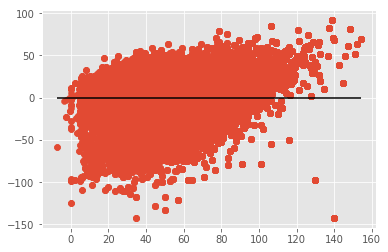

In [19]:
# It looks like when the model is off, it is off by a lot.  
predictions = model.predict(X)
# Plot Residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()
# Maybe there are groups of similar plays that we are fitting into a regression that should be identified on their own
# First though, lets try adding a more full dataset

In [20]:
# save the model to disk
filename = 'model_V1.sav'
pickle.dump(model, open(filename, 'wb'))

In [21]:
# first model filename = 'model_V1.sav
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.3855246571636721


In [22]:
# Next, I tried running a linear regression model on the more flushed out data set, but it gave me a negative R^2
# R2 Score: -890607803623.632
# And the model literally took 30 minutes to run so I moved on to other models

In [23]:
# After more reading, I decided upon a Decision Tree model
# DT Models don't just use one line, and can better cut up the data using multiple lines 
# This allows us to identify patterns between teams, quarters, defenses and players
# They help when the impurity of the data, or the amount of overlap between variables, is high

In [24]:
# NFL8_DF.values.reshape((362447, 3))
# Split data into training and testing
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=42)

In [25]:
target = final_df["Yards.GainedComputed_"]
target_names = ["negative", "positive"]

In [26]:
# Create New Dataframes
data = final_df.drop("Yards.GainedComputed_", axis=1)
feature_names = data.columns
data.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,T.Tebow,T.Thigpen,T.Way,T.Yates,V.Young,W.Snead,Z.Mettenberger,ards. Backward,haun.Hill,iver. Ryan
0,2009-09-10,2009091000,1,1,0.0,15:00,15,3600.0,0.0,TEN,...,0,0,0,0,0,0,0,0,0,0
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,0,0,0,0,0,0,0,0,0,0
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,0,0,0,0,0,0,0,0,0,0
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,0,0,0,0,0,0,0,0,0,0
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# Train Decision Tree Model
print("That looks much better!")
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X1_train, y1_train)
clf.score(X1_test, y1_test)

That looks much better!


0.8745736071165808

In [28]:
# save the model to disk
filename = 'DecisionTreeV1.sav'
pickle.dump(clf, open(filename, 'wb'))

In [29]:
final_df.loc[0:5, final_df.head().applymap(lambda x: x == "None").any()]

,Passer_ID,Rusher_ID,Receiver_ID,Timeout_Team
0,None,None,None,None
1,00-0022924,None,00-0017162,None
2,None,00-0022250,None,None
3,00-0022924,None,00-0026901,None
4,None,None,None,None
5,None,00-0026164,None,None


In [30]:
# Split data into training and testing
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42)

In [31]:
# Train Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=2, random_state=0)
rfcFIT = clf.fit(X1_train, y1_train)
rfcFIT.score(X1_test, y1_test)

0.8741555748779346

In [32]:
# save the model to disk
filename = 'RandomForestClassifierV1.sav'
pickle.dump(rfcFIT, open(filename, 'wb'))

In [33]:
# I added everything to the model and it actually gets worse
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=2, random_state=0)
rfcFIT = clf.fit(X2_train, y2_train)
rfcFIT.score(X2_test, y2_test)

0.8425263761974131

In [34]:
# save the model to disk
filename = 'RandomForestClassifierV2.sav'
pickle.dump(rfcFIT, open(filename, 'wb'))

In [35]:
# Use the forest's predict method on the test data
predictions = rfcFIT.predict(X2_test)
# Calculate the absolute errors
errors = abs(predictions - y2_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print("Mean absolute error (MAE) is a measure of difference between two continuous variables.")

Mean Absolute Error: 3.38 degrees.
Mean absolute error (MAE) is a measure of difference between two continuous variables.


In [36]:
# Saving feature names for later use
feature_list = list(data.columns)
# Get numerical feature importances
importances = list(rfcFIT.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TimeSecs             Importance: 0.21
Variable: down                 Importance: 0.13
Variable: Date                 Importance: 0.11
Variable: time                 Importance: 0.08
Variable: GameID               Importance: 0.03
Variable: TimeUnder            Importance: 0.03
Variable: Drive                Importance: 0.02
Variable: PlayTimeDiff         Importance: 0.01
Variable: SideofField          Importance: 0.01
Variable: yrdln                Importance: 0.01
Variable: yrdline100           Importance: 0.01
Variable: ydstogo              Importance: 0.01
Variable: ydsnet               Importance: 0.01
Variable: GoalToGo             Importance: 0.01
Variable: FirstDown            Importance: 0.01
Variable: posteam              Importance: 0.01
Variable: DefensiveTeam        Importance: 0.01
Variable: desc                 Importance: 0.01
Variable: PlayAttempted        Importance: 0.01
Variable: Yards.Gained         Importance: 0.01
Variable: sp                   Importanc

In [37]:
# Neural Network

In [38]:
from sklearn.preprocessing import StandardScaler

X1_scaler = StandardScaler().fit(X1_train)

In [39]:
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [40]:
from keras.utils import to_categorical

# One-hot encoding
y1_train_categorical = to_categorical(y1_train)
y1_test_categorical = to_categorical(y1_test)
y1_train_categorical

/Users/nicholashebert/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/nicholashebert/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
from keras.models import Sequential

model = Sequential()

In [42]:
from keras.layers import Dense
number_inputs = 1899
number_hidden_nodes = 4
model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))

In [43]:
number_classes = 283
model.add(Dense(units=number_classes, activation='softmax'))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 7600      
_________________________________________________________________
dense_2 (Dense)              (None, 283)               1415      
Total params: 9,015
Trainable params: 9,015
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Use categorical crossentropy for categorical data and mean squared error for regression
# Hint: your output layer in this example is using software for logistic regression (categorical)
# If your output layer activation was `linear` then you may want to use `mse` for loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fit (train) the model
model.fit(
    X1_train_scaled,
    y1_train_categorical,
    epochs=200,
    shuffle=True,
    verbose=2
)

Epoch 1/200
 - 47s - loss: 4.6304 - acc: 0.0347
Epoch 2/200
 - 38s - loss: 4.4787 - acc: 0.0408
Epoch 3/200
 - 35s - loss: 4.4567 - acc: 0.0419
Epoch 4/200
 - 51s - loss: 4.4466 - acc: 0.0418
Epoch 5/200
 - 37s - loss: 4.4407 - acc: 0.0424
Epoch 6/200
 - 33s - loss: 4.4374 - acc: 0.0422
Epoch 7/200
 - 33s - loss: 4.4352 - acc: 0.0420
Epoch 8/200
 - 44s - loss: 4.4340 - acc: 0.0421
Epoch 9/200
 - 36s - loss: 4.4344 - acc: 0.0421
Epoch 10/200
 - 32s - loss: 4.4334 - acc: 0.0422
Epoch 11/200
 - 32s - loss: 4.4336 - acc: 0.0422
Epoch 12/200
 - 37s - loss: 4.4335 - acc: 0.0424
Epoch 13/200
 - 33s - loss: 4.4333 - acc: 0.0420
Epoch 14/200
 - 33s - loss: 4.4328 - acc: 0.0424
Epoch 15/200
 - 36s - loss: 4.4323 - acc: 0.0422
Epoch 16/200
 - 40s - loss: 4.4335 - acc: 0.0421
Epoch 17/200
 - 35s - loss: 4.4331 - acc: 0.0420
Epoch 18/200
 - 37s - loss: 4.4329 - acc: 0.0419
Epoch 19/200
 - 37s - loss: 4.4321 - acc: 0.0419
Epoch 20/200
 - 39s - loss: 4.4332 - acc: 0.0422
Epoch 21/200
 - 34s - loss: 4

Epoch 167/200
 - 40s - loss: 4.4378 - acc: 0.0419
Epoch 168/200
 - 32s - loss: 4.4370 - acc: 0.0417
Epoch 169/200
 - 32s - loss: 4.4375 - acc: 0.0422
Epoch 170/200
 - 31s - loss: 4.4385 - acc: 0.0421
Epoch 171/200
 - 36s - loss: 4.4382 - acc: 0.0420
Epoch 172/200
 - 36s - loss: 4.4372 - acc: 0.0424
Epoch 173/200
 - 36s - loss: 4.4372 - acc: 0.0419
Epoch 174/200
 - 36s - loss: 4.4373 - acc: 0.0421
Epoch 175/200
 - 36s - loss: 4.4378 - acc: 0.0418
Epoch 176/200
 - 43s - loss: 4.4384 - acc: 0.0422
Epoch 177/200
 - 39s - loss: 4.4380 - acc: 0.0421
Epoch 178/200
 - 52s - loss: 4.4369 - acc: 0.0420
Epoch 179/200
